# Titanic survival prediction for Kaggle competition

Import relevant libraries

In [1]:
import numpy as np # for linear algebra
import pandas as pd # for data handling
import matplotlib.pyplot as plt

The data has been previoulsy split into train and test data. 
It is a better practice is to separate the data into train, dev and test samples in different proportions depending on dataset size; an usual split would be 10-10-80% respectively.

In [2]:
#df_train = pd.read_csv("data/train.csv", index_col='PassengerId')
#df_test  = pd.read_csv("data/test.csv", index_col='PassengerId')
df_train = pd.read_csv("data/train.csv")
df_test  = pd.read_csv("data/test.csv")

## Data exploration and manipulating
Let's explore the data to look at what kind of information we have, to see if there are any missing values or characters and standarize our sets.

In [3]:
print('Train tail\n', df_train.tail())
print('\n\nTest head\n', df_test.head())

Train tail
      PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q  


Test head
    PassengerId  Pclass                                          Name     Sex  \
0     

In [4]:
#Print train info/summary
print(df_test.info())
print('\n\n', df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


        PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.18120

### Dealing with missing values

We see that 'Cabin' is obviously mostly NaN so let's get rid of that information. The ticket fare is reflected in the class 'Pclass' so we'll remove it too.
It wouldn't hurt to leave that column as the dataset is small but we might work with larger samples in the future.
For the other variables, we'd like to see how many different inputs there are so we can standarize the data.

In [5]:
drop_columns = ['Cabin', 'Fare', 'Name', 'Ticket']
df_train.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1, inplace=True)
df_test.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1, inplace=True)
#df_test.drop(columns=drop_columns, inplace=True)

In [6]:
#Print the unique values in the different train variables
print('=== Unique TRAIN values ===')
for col in df_train.columns: 
    print('\n'+col+'\n', df_train[col].unique())
    
print('\n\n=== Unique TEST values ===')
for col in df_test.columns: 
    print('\n'+col+'\n', df_test[col].unique())
    
df_train['Survived'].value_counts()

=== Unique TRAIN values ===

PassengerId
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 

0    549
1    342
Name: Survived, dtype: int64

We notice that there are a few entries where the age data is missing. Explicitly,

In [7]:
#print('Missing values = ', (df_test[(df_test['Age']).isnull()]).count() ,' out of ', df_test.shape[0], 'entries')
#print percentaje of missing rows
df_train.isna().sum()/(len(df_train))*100
df_test.isna().sum()/(len(df_test))*100

PassengerId     0.000000
Pclass          0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Embarked        0.000000
dtype: float64

As the percentage of missing age values is not negligible (about 20%), we can take the following approaches: Split male from females and
* Assign the mean of each gender ages
* Assign the mode of the specific gender age

(array([23.,  5.,  9., 14., 51., 58., 62., 55., 47., 27., 23., 23., 19.,
        10.,  8.,  8.,  4.,  5.,  1.,  1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <BarContainer object of 20 artists>)

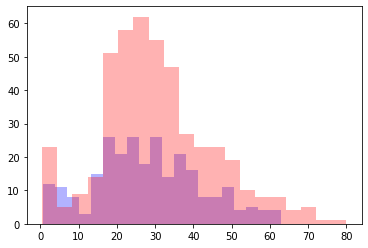

In [8]:
male_mask = (df_train['Sex'] == 'male')
female_mask = (df_train['Sex'] == 'female')
plt.hist(df_train['Age'].mask(male_mask), bins=20, alpha = 0.3, color='blue')
plt.hist(df_train['Age'].mask(female_mask), bins=20, alpha = 0.3, color='red')

In [9]:
#define gender masks to compute values to use and to replace the 999s
m_mask = (df_train['Sex'] == 'male')
f_mask = (df_train['Sex'] == 'female')

#get gender age means
m_age_mean = df_train.loc[df_train['Sex'] == 'male', 'Age'].mean()
f_age_mean = df_train.loc[df_train['Sex'] == 'female', 'Age'].mean()
m_age_mode = df_train.loc[df_train['Sex'] == 'male', 'Age'].mode() # mode is giving zeros
f_age_mode = df_train.loc[df_train['Sex'] == 'female', 'Age'].mode() # mode is giving zeros

print('Mean | Mode')
print('Male: ',  m_age_mode, ' | ', m_age_mean)
print('Female: ',  f_age_mode, ' | ', f_age_mean)

#hacky hack because I couldn't mask using "and == 'NaN'"
#replace nans with 999 in both data sets
df_train.Age = df_train.Age.fillna(999)
df_test.Age = df_test.Age.fillna(999)

df_train['Age'].mask(m_mask & (df_train['Age'] == 999), m_age_mean, inplace=True)
df_train['Age'].mask(f_mask & (df_train['Age'] == 999), f_age_mean, inplace=True)
df_test['Age'].mask(m_mask & (df_test['Age'] == 999), m_age_mean, inplace=True)
df_test['Age'].mask(f_mask & (df_test['Age'] == 999), f_age_mean, inplace=True)

#replace string sex with binary
df_train['Sex'] = df_train['Sex'].replace(['male'],0)
df_train['Sex'] = df_train['Sex'].replace(['female'],1)
df_test['Sex'] = df_test['Sex'].replace(['male'],0)
df_test['Sex'] = df_test['Sex'].replace(['female'],1)

#change variable types
df_train['Sex'] = df_train['Sex'].astype('int')
df_test['Sex'] = df_test['Sex'].astype('int')
#the _y_ colum needs to be an integer
df_train['Survived'] = df_train['Survived'].astype('int')

print('\n\n\n',df_train)

Mean | Mode
Male:  0    19.0
1    25.0
2    28.0
dtype: float64  |  30.72664459161148
Female:  0    24.0
dtype: float64  |  27.915708812260537



      PassengerId  Survived  Pclass  Sex        Age  SibSp  Parch Embarked
0              1         0       3    0  22.000000      1      0        S
1              2         1       1    1  38.000000      1      0        C
2              3         1       3    1  26.000000      0      0        S
3              4         1       1    1  35.000000      1      0        S
4              5         0       3    0  35.000000      0      0        S
..           ...       ...     ...  ...        ...    ...    ...      ...
886          887         0       2    0  27.000000      0      0        S
887          888         1       1    1  19.000000      0      0        S
888          889         0       3    1  27.915709      1      2        S
889          890         1       1    0  26.000000      0      0        C
890          891         0       3    0

# Binary classification methods

There are different methods to approach a binary classification problem such as the _Titanic survival_, each of them with advantages depending on the dataset size and independent variables to be used:

* Logistic regression is the most basic and popular classification algorithm.
* K-nearest neighbours (KNN) groups data points based on simmilarities. 
* Support vector machine (SPV) 
* Decission tree makes decissions based on if-else
* Neural network

## Logistic Regression

In [10]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import scipy.optimize as opt
#plt.scatter(train_x, train_y, color = 'blue')

Let's define X and y in the datasets considering only the variables that we consider relevant to the prediction. Our logistic regression frontend takes arrays as an input.

In [11]:
X_train = np.asarray(df_train[['Age', 'Sex', 'Pclass']])
y_train = np.asarray(df_train[['Survived']])
X_test = np.asarray(df_test[['Age', 'Sex', 'Pclass']])

We also need to scale the data

In [12]:
from sklearn import preprocessing
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_train[0:5]

array([[-0.59473226, -0.73769513,  0.82737724],
       [ 0.63531868,  1.35557354, -1.56610693],
       [-0.28721953,  1.35557354,  0.82737724],
       [ 0.40468413,  1.35557354, -1.56610693],
       [ 0.40468413, -0.73769513,  0.82737724]])

In [13]:
y_train = y_train.reshape(y_train.shape[0],) # reshape to no second dimension. that's the input for the class label.

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape)

Train set: (891, 3) (891,)
Test set: (418, 3)


Logistic regression with regularization term _C_

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR = LogisticRegression(solver='lbfgs').fit(X_train,y_train)
LR

LogisticRegression()

Now we predict using the test set

In [15]:
y_pred_lr = LR.predict(X_test)
y_pred_lr

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

**predict_proba**  returns estimates for all classes (in our case 0 or 1), ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1, P(Y=1|X):

In [16]:
yhat_prob_lr = LR.predict_proba(X_test)
#yhat_prob

**Output prediction**

In [23]:
y_pred_lr = pd.DataFrame(y_pred_lr)
y_pred_lr.index +=892
y_pred_lr.to_csv("pred_lr.csv")

## K-Nearest Neighbours

In [18]:
from sklearn.neighbors import KNeighborsClassifier

#Train Model and Predict using 5 neighbours for now
k = 5
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier()

In [19]:
y_pred_knn = neigh.predict(X_test)
y_pred_knn

#output prediction
y_pred_knn = pd.DataFrame(y_pred_knn)
y_pred_knn.index +=892
y_pred_knn.to_csv("pred_knn.csv")

## Support Vector Machine

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

Lets see how the different data variables are related in the 3D space

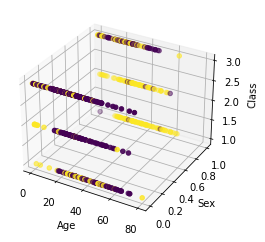

In [20]:
#ax = df_train[df_train['Survived'] == 1][0:50].plot(kind='scatter', x='Age', y='Sex', color='DarkBlue', label='Survived');
#df_train[df_train['Survived'] == 0][0:50].plot(kind='scatter', x='Age', y='Sex', color='Yellow', label='Died', ax=ax);
#plt.show()

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Class');

ax.scatter3D(df_train[['Age']], df_train[['Sex']], df_train[['Pclass']], c=df_train[['Survived']])

In [21]:
from sklearn import svm
# use 'radial basic function'
# linear, polynomial and sigmoid also exist
clf = svm.SVC(kernel='rbf').fit(X_train, y_train) 
clf

SVC()

In [22]:
y_pred_svc = clf.predict(X_test)
y_pred_svc

#output prediction
y_pred_svc = pd.DataFrame(y_pred_svc)
y_pred_svc.index +=892
y_pred_svc.to_csv("pred_svc.csv")

## Model performance evaluation

We don't have the true survival labels so we can't compute the accuracy of the model... (?)